In [16]:
import pandas as pd
import numpy as np
import requests
import branca
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression, Lasso
import statsmodels.api as sm

In [41]:
def do_tag(df):
    df = df.reset_index(drop=True)
    #----------------------------------------------------
    # Extract all category tags for italian restaurants
    def get_cat(df):
        N = len(df)
        italian_cat = []
        for i in range(N):
            italian_cat.extend(df.categories[i])
        italian_cat_set = set(italian_cat)
        return italian_cat_set
    
    #----------------------------------------------------
    # Make each tag a column and add to df
    italian_cat_set = get_cat(df)
    italian_cat_set.remove('italian')
    for i in italian_cat_set:
        df[str(i)]=[(str(i) in df.categories[j])*1 for j in range(len(df))]
    
    #----------------------------------------------------
    # Create a new df only with all categories
    index = list(df.index.unique().values)
    columns = list(italian_cat_set)
    df_new = pd.DataFrame(index=index, columns=columns)
    
    # Add tag columns to df_new to fit linear model
    df_new['rating'] = df['rating']
    for i in italian_cat_set:    
        df_new[str(i)]=df[str(i)]
          
    #----------------------------------------------------
    # Apply Linear Regression to df_new to get most effective tags
    Y = df_new['rating']
    X = df_new[columns]
    model = LinearRegression().fit(X,Y)
    intercept = model.intercept_
    coef = model.coef_
    # Find top 5 tags
    d = list(zip(coef,columns))
    do_not_tag = sorted(d)[:5]
    do_tag = sorted(d)[-5:]
    do_tag_cat = [tag[1] for tag in do_tag]
    do_not_tag_cat = [tag[1] for tag in do_not_tag]
    
#     print(italian_cat_set)
#     print('Do Tag: ',do_tag_cat)
#     print('Do Not Tag: ',do_not_tag_cat)
    return do_tag_cat, do_not_tag_cat

In [42]:
def service(df):
    df = df.reset_index(drop=True)
    #----------------------------------------------------
    # Create a new df only with all categories
    index = list(df.index.unique().values)
    columns = ['pickup','delivery','restaurant_reservation']
    df_service = pd.DataFrame(index=index, columns=columns)
    
    # Add tag columns to df_new to fit linear model
    df_service['rating'] = df['rating']
    for i in columns:    
        df_service[str(i)]=df[str(i)]*1
    
    #--------------------------------------------------------------------------
    # Apply Linear Regression on Service Types to find how significant they are
    Y = df_service['rating']
    X = df_service[columns]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    result = model.fit()
    parameter = result.params[1:]
    pvalue = result.pvalues[1:]
    
    # Store model outputs for service types
    service_dict = {}
    for i in range(len(columns)):
        if parameter[i]>0:
            service_dict[columns[i]] = parameter[i]
    service_dict
    
    # Record pvalues for later use
    pvalue_dict={}
    for i in range(len(columns)):
        pvalue_dict[columns[i]+'_p_value'] = pvalue[i]
    pvalue_dict
    
#     print('Significance of Service Types:', service_dict)
#     print('P-value of Service Types:', pvalue_dict)
    return service_dict, pvalue_dict

In [43]:
def avg_price(df):
    df = df.reset_index(drop=True)
    avg_price = np.mean(df['price_num'])
    return avg_price

In [44]:
def avg_rate(df):
    df = df.reset_index(drop=True)
    avg_rate = np.mean(df['avg_rate'])
    return avg_rate

In [45]:
# read all italian restaurants
df = pd.read_pickle("./italian_review_551.pkl")

In [46]:
df_new = df[['longitude','latitude']]

In [47]:
# clustering
np.random.seed(0)
from sklearn.cluster import KMeans
# number of clusters
k = 5
kmeans = KMeans(n_clusters=k,n_init=30)
# fitting the input data
kmeans = kmeans.fit(df_new)
# getting the cluster labels
labels = kmeans.predict(df_new)
# centroid values
centroids = kmeans.cluster_centers_

In [48]:
df['label'] = labels
area_label = np.unique(df['label'])

In [49]:
print(centroids)

[[-73.98057001  40.76445118]
 [-73.99983004  40.72339522]
 [-73.93448251  40.84954605]
 [-73.98835069  40.73839707]
 [-73.9568894   40.78471502]]


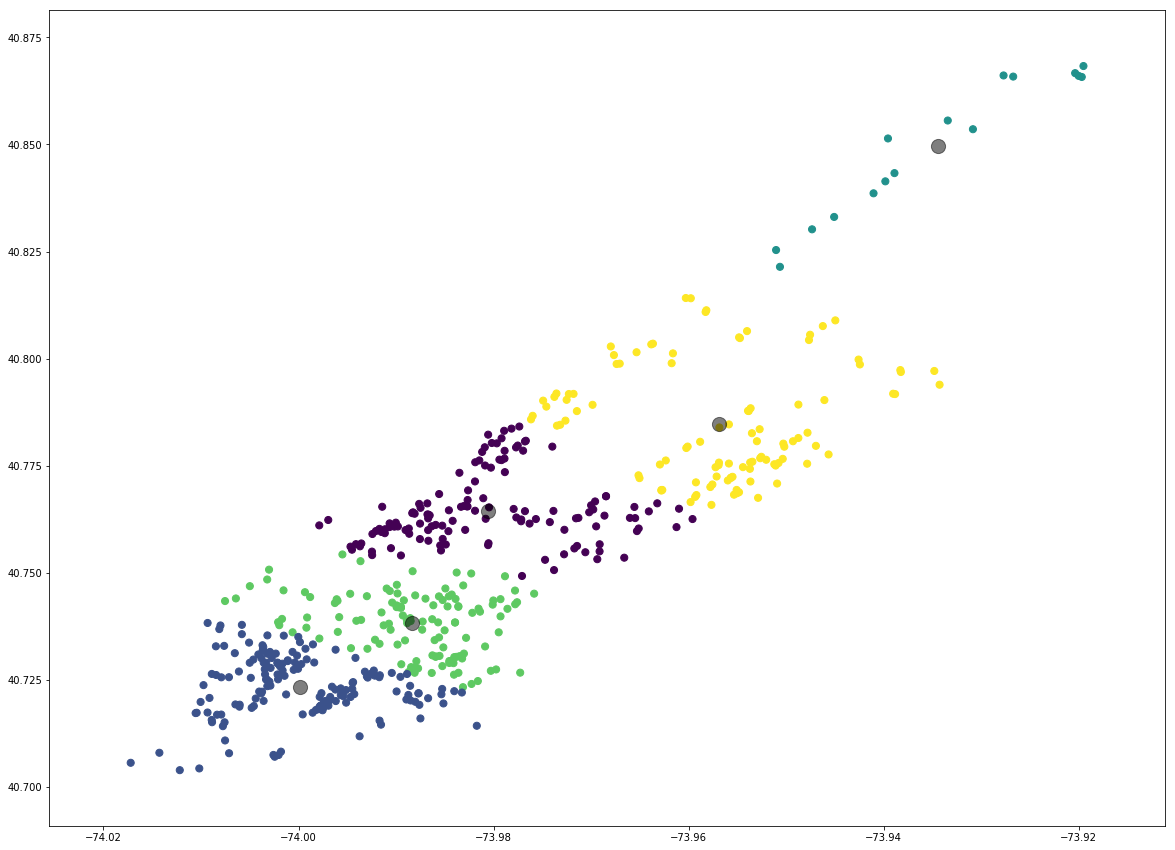

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.scatter(df_new['longitude'], df_new['latitude'], c=labels, s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)

In [51]:
def fancy_table(df,row):
    i = row
    title = 'Analysis of Cluster ' + str(i)
    average_price = df['average price'].iloc[i]                             
    recommended_tags = df['recommended tags'].iloc[i]                           
    non_recommended_tags = df['non-recommended tags'].iloc[i]
    average_rating = df['average rating'].iloc[i]                                           
    recommended_service = df['recommended service'].iloc[i]                               
    
    left_col_colour = "#2A799C"
    right_col_colour = "#C5DCE7"
    
    html =  """<!DOCTYPE html>
            <html>

            <head>
            <h4 style="margin-bottom:0"; width="600px">{}</h4>""".format(title) + """

            </head>
                <table style="height: 126px; width: 600px;">
            <tbody>
            <tr>
            <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Average Rating</span></td>
            <td style="width: 600px;background-color: """+ right_col_colour +""";">{}</td>""".format(average_rating) + """
            </tr>
            <tr>
            <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Average Price Level</span></td>
            <td style="width: 600px;background-color: """+ right_col_colour +""";">{}</td>""".format(average_price) + """
            </tr>
            <tr>
            <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Tags Recommended</span></td>
            <td style="width: 600px;background-color: """+ right_col_colour +""";">{}</td>""".format(recommended_tags) + """
            </tr>
            <tr>
            <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Tags Not Recommended</span></td>
            <td style="width: 600px;background-color: """+ right_col_colour +""";">{}</td>""".format(non_recommended_tags) + """
            </tr>
            <tr>
            <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Recommended Service</span></td>
            <td style="width: 600px;background-color: """+ right_col_colour +""";">{}</td>""".format(recommended_service) + """
            </tr>
            </tbody>
            </table>
            </html>
            """
    return html

In [52]:
df_cluster = pd.DataFrame(columns=['recommended tags','non-recommended tags','average price','average rating','recommended service'],index=list(range(5)))
for i in range(5):
    df_cluster['recommended tags'].iloc[i] = do_tag(df[df['label']==i])[0]
    df_cluster['non-recommended tags'].iloc[i] = do_tag(df[df['label']==i])[1]
    df_cluster['recommended service'].iloc[i] = list(service(df[df['label']==i])[0].keys())
    df_cluster['average price'].iloc[i] = avg_price(df[df['label']==i])
    df_cluster['average rating'].iloc[i] = avg_rate(df[df['label']==i])

/Users/qihanliang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/qihanliang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/qihanliang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/qihanliang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [53]:
zip_groups = df.groupby("zip")
sizes = pd.DataFrame(zip_groups.size())
sizes.rename(columns={0:"size"},inplace=True)
sizes.reset_index(level=0, inplace=True)
import folium
from folium.plugins import MarkerCluster
#Center the map at Times Square
m = folium.Map(width=1200,height=1200,location = [40.7589,-73.9851],zoom_start=12)

# clustered marker
marker_cluster = MarkerCluster().add_to(m)
for i in range(len(df_new)):
    
    if df['label'].iloc[i] == 0:
        folium.Marker(location=[df_new['latitude'].iloc[i],df_new['longitude'].iloc[i]],
        popup=df['name'].iloc[i],
        icon=folium.Icon(color='red')
        ).add_to(marker_cluster)   
    elif df['label'].iloc[i] == 1:
        folium.Marker(location=[df_new['latitude'].iloc[i],df_new['longitude'].iloc[i]],
        popup=df['name'].iloc[i],
        icon=folium.Icon(color='orange')
        ).add_to(marker_cluster)
    elif df['label'].iloc[i] == 2:
        folium.Marker(location=[df_new['latitude'].iloc[i],df_new['longitude'].iloc[i]],
        popup=df['name'].iloc[i],
        icon=folium.Icon(color='green')
        ).add_to(marker_cluster)
    elif df['label'].iloc[i] == 3:
        folium.Marker(location=[df_new['latitude'].iloc[i],df_new['longitude'].iloc[i]],
        popup=df['name'].iloc[i],
        icon=folium.Icon(color='purple')
        ).add_to(marker_cluster)
    else:
        folium.Marker(location=[df_new['latitude'].iloc[i],df_new['longitude'].iloc[i]],
        popup=df['name'].iloc[i],
        icon=folium.Icon(color='black')
        ).add_to(marker_cluster)
        
# choropleth map
m.choropleth(geo_data='zipcode.geojson', data=sizes,
             columns=[ 'zip','size'],
             key_on='feature.properties.postalCode',
             fill_color='RdYlGn', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Distribution of Incidents')
folium.LayerControl().add_to(m)

########### Add centroids on the map #################
for i in range(5):
    html = fancy_table(df_cluster,i) 
    iframe = branca.element.IFrame(html=html,width=600,height=300)
    popup = folium.Popup(iframe,parse_html=True)
    if i == 0:
        folium.Marker([centroids[i][1],centroids[i][0]],popup=popup,icon=folium.Icon(color='red',icon='home')).add_to(m)
    elif i == 1:
        folium.Marker([centroids[i][1],centroids[i][0]],popup=popup,icon=folium.Icon(color='orange',icon='home')).add_to(m)
    elif i == 2:
        folium.Marker([centroids[i][1],centroids[i][0]],popup=popup,icon=folium.Icon(color='green',icon='home')).add_to(m)
    elif i == 3:
        folium.Marker([centroids[i][1],centroids[i][0]],popup=popup,icon=folium.Icon(color='purple',icon='home')).add_to(m)
    else:
        folium.Marker([centroids[i][1],centroids[i][0]],popup=popup,icon=folium.Icon(color='black',icon='home')).add_to(m)
m

/Users/qihanliang/anaconda3/lib/python3.7/site-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
